# Multi layer perceptron model
This is an improved approach of predicting names from the bigram_model and is based on three layers:
1. The embedding matrix layer
2. One hidden layer 
3. Logits / log-counts

The architecture of the model follows from Bengio et al. 2003. along side Andrej Karparthy's series of makemore. see reference

## 1. Embedding matrix layer
- An **embedding** is a mapping of discrete symbols to continuous vectors.
    - Text is embedded (converted) to vectors (numerical values) for better analysis
- An **embedding matrix** is a list of all text and their corresponding embeddings.
    - each row represents an embedding (vector) for a text.
    - each column represents the dimension of an embedding.
        - size of dimension: choosing the size of the dimension is arbitrary.
   
## 2. Hidden layer
- The hidden layer is made up of 200 neurons chosen arbitrarily.
- Inputs of the hidden inputs are block_size * dim, where:
    - block_size is the number of characters used to predict the next one
    - dim: The dimension of each embedding vector
- We used tanh as the activation function in the hidden layer

## 3. Logits / log-counts
- There are 27 logits in the final layer. 26 for all letters and 1 for the ending special character
- The final layer has a softmax function that creates a  probability distribution of the 27 possible outcomes.

## Reference
1. Bengio, Y.et al. 2003. *A Neural Probabilistic Language Model.* Available at: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf (Accessed 27 December 2022). 

2. Karparthy (2022) *Building makemore Part 2: MLP.* Available at: https://www.youtube.com/watch?v=TCH_1BHY58I (Accessed 27 December 2022).

3. Golberg, Y. 2017. *Neural Network Methods for Natural Language Processing.* Lonoon: Morgan & Claypool

In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Build the dataset

In [2]:
words = open('data/names.txt','r').read().splitlines()

# get all characters from words
chars = sorted(list(set(''.join(words))))

# look up dictionary of characters: string to integer(stoi) mapping
stoi = {letter:index+1 for index, letter in enumerate(chars)}

# start and end special character
stoi['.'] = 0

# # look up dictionary of character indexes: integer to string mapping
itos = {letter:index for index, letter in stoi.items()} 

# function that splits words into inputs(X) of size block_size and outputs (Y)
def build_dataset(words, block_size):
    # block_size: number of characters used to predict the next character
    X,Y= [],[]
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #remove first item and append last

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(f'X shape:{X.shape}, Y shape: {Y.shape}')
    return X, Y

### Split the dataset in three parts
1. Training data
2. Validation data
3. Test data

In [3]:
block_size = 4
random.seed(42)

random.shuffle(words)

n1 = int(0.8*len(words)) # training split (80%)
n2 = int(0.9*len(words)) #validation split (10%)

#Split dataset into training, validation, and evaluation phases

#training split (80%): for optimising parameters of model
Xtr, Ytr = build_dataset(words[:n1], block_size)

#dev/validation split (10%): for development over all hyperparameters of model
Xdev, Ydev = build_dataset(words[n1:n2], block_size)

# test split (10%): to evaluate the performance of the model at the end
Xtest, Ytest = build_dataset(words[n2:], block_size)

X shape:torch.Size([182625, 4]), Y shape: torch.Size([182625])
X shape:torch.Size([22655, 4]), Y shape: torch.Size([22655])
X shape:torch.Size([22866, 4]), Y shape: torch.Size([22866])


### Initialize the network

In [4]:
#seed
g = torch.Generator().manual_seed(710)

#build the embedding matrix
dim = 60 #number of dimensions/columns, chosen arbitrarily
# There are 27 possible characters,i.e. length of stoi
C = torch.randn((len(stoi),dim), generator=g)

#construct hidden layer
num_inputs = block_size*dim
num_neurons = 200 #arbitrary
#weights
W1 = torch.randn((num_inputs,num_neurons),generator=g)
#bias
b1 = torch.randn(num_neurons,generator=g)

#construct final layer
num_inputs = num_neurons
num_neurons = 27 
#weights
W2 = torch.randn((num_inputs,num_neurons),generator=g)*0.01 
#bias
b2 = torch.randn(num_neurons,generator=g)*0


# function that foward propagates the network
def foward_pass(X, Y=None):
    emb = C[X] #embedded matrix
    h = torch.tanh(emb.view(emb.shape[0],block_size*dim)@W1 + b1) #hidden layer
    logits = h @ W2 + b2 #log-counts

    return F.softmax(logits,dim=1) if Y is None else F.cross_entropy(logits,Y)

#cluster all parameters into single list
parameters = [C, W1, b1, W2, b2]
print(f'sum of parameters: {sum(p.nelement() for p in parameters)}')

for p in parameters:
    p.requires_grad = True

sum of parameters: 55247


### Train the network

In [5]:
#keep track of learning rates and losses based on learing rates
losses, steps = [],[] 
batch_size, iters =32, 200000
for i in range(iters):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0],(batch_size,))
    
    #foward pass
    loss = foward_pass(Xtr[ix], Ytr[ix])

    #backward pass
    for p in parameters:
        p.grad = None #set gradients to zero
    loss.backward() #populate gradients
    
    #update parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i%10000==0:
        print(f'{i:7d}/{iters:7d} : {loss.item():.4f}')
    losses.append(loss.log10().item())
    steps.append(i)
    

      0/ 200000 : 3.2750
  10000/ 200000 : 1.9456
  20000/ 200000 : 2.3292
  30000/ 200000 : 1.9036
  40000/ 200000 : 2.2044
  50000/ 200000 : 2.2857
  60000/ 200000 : 1.8274
  70000/ 200000 : 2.3535
  80000/ 200000 : 2.4402
  90000/ 200000 : 2.4963
 100000/ 200000 : 2.0374
 110000/ 200000 : 2.1880
 120000/ 200000 : 1.9607
 130000/ 200000 : 1.9276
 140000/ 200000 : 2.0275
 150000/ 200000 : 1.7357
 160000/ 200000 : 1.9887
 170000/ 200000 : 2.1507
 180000/ 200000 : 2.1251
 190000/ 200000 : 1.8419


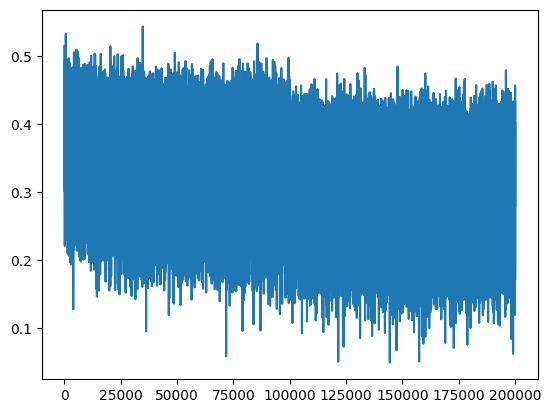

In [6]:
_ = plt.plot(steps,losses) #for checking learning rate

In [7]:
#loss on training data
with torch.no_grad():
    print(f'loss on training data: {foward_pass(Xtr, Ytr).item(): .4f}')

loss on training data:  1.9924


In [8]:
#Vdev/validation of the model
with torch.no_grad():
    print(f'loss on validation data: {foward_pass(Xdev, Ydev).item(): .4f}')


loss on validation data:  2.1202


### Sample from the model

In [9]:
g = torch.Generator().manual_seed(710)

for _ in range(10):
    out = []
    context = [0]*block_size
    while True:
        with torch.no_grad():
            probs = foward_pass(torch.tensor([context])) 
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

jaciel.
emmo.
mica.
shanensim.
hylie.
sanch.
roam.
davin.
hadlyon.
intiton.
